# Employee Turnover Prediction

In [102]:
#Environment set up | libraries installed
from sklearn.linear_model import LogisticRegression
from typing import List
from skrebate import ReliefF
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.utils import resample
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import PolynomialFeatures

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import statsmodels.api as sm
import sklearn.model_selection as modsel

In [103]:
#Upload of the original data - ref. turnover
turnover = pd.read_csv (r'C:\Users\Ani\Desktop\IE\Projects and exams\ML II\turnover.csv')

# Data exploration

#Basic description and preview of the data
turnover.info()
turnover.head()

In [104]:
#Correcting typo in column
turnover.columns = turnover.columns.str.replace('average_montly_hours', 'average_monthly_hours')

In [77]:
#Running statistics to analyze the distribution of numerical feature values
turnover.describe()
#Check for missing values - none
turnover.isnull().any()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000014804D900C8>,
      dtype=object)

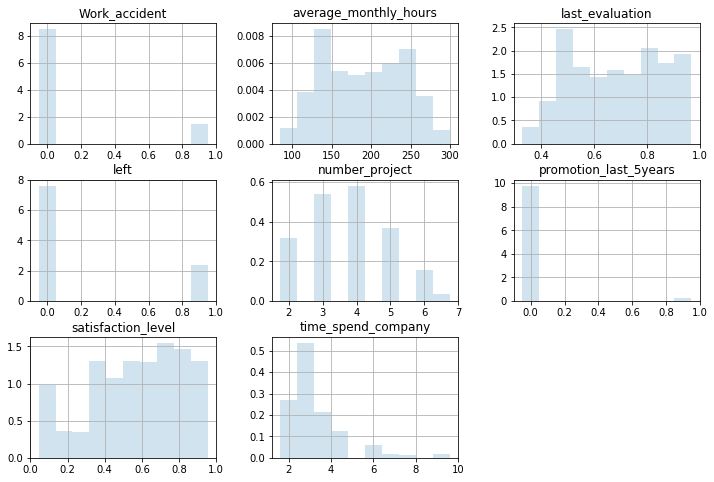

In [78]:
#Histogram for numerical variables
turnover.hist(histtype='stepfilled', alpha=0.2, density=True, align = 'left',orientation='vertical',stacked=False,figsize=(12,8))

-0.09497080755116631

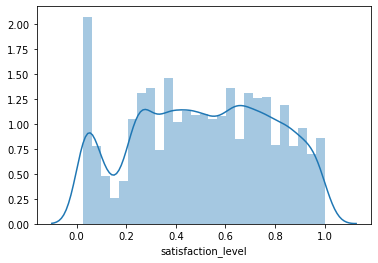

In [79]:
#By looking at histograms the feature that requires most correction of skewness is satisfaction_level. Increasing to power 1.5.
turnover.loc[:,'satisfaction_level'] = turnover['satisfaction_level']**(1.5)
sq_sat=turnover['satisfaction_level']
sns.distplot(sq_sat)
sq_sat.skew()

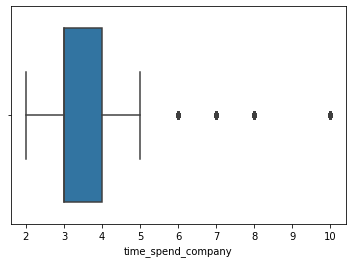

In [60]:
#Visualize outliers for tenure in the company, which seems to be the only feature relevant for outlier detection. 
sns.boxplot(turnover['time_spend_company'])

In [80]:
#for analyzing categorical variables together
num_variables = turnover.select_dtypes(include = ['object'])
Count = turnover.groupby('salary').size()
Count2 = turnover.groupby('sales').size()

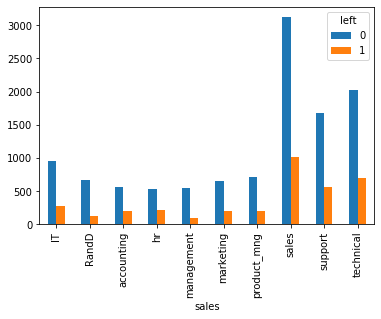

In [61]:
pd.crosstab(turnover.sales,turnover.left).plot(kind='bar')
#Reducing the number of department categories and groupomg by similar functions.
#Sales the most employees and most leavers and must be the driving area of the company.
#We can group support and technical and all other cross functions (HR, accounting ets) into others since they are support functions to business.
turnover['sales']=np.where(turnover['sales'] =='support', 'technical', turnover['sales'])
turnover['sales']=np.where(turnover['sales'] =='RandD', 'Other', turnover['sales'])
turnover['sales']=np.where(turnover['sales'] =='hr', 'Other', turnover['sales'])
turnover['sales']=np.where(turnover['sales'] =='accounting', 'Other', turnover['sales'])
turnover['sales']=np.where(turnover['sales'] =='product_mng', 'marketing', turnover['sales'])
turnover['sales']=np.where(turnover['sales'] =='management', 'sales', turnover['sales'])

In [62]:
#The most sensitive feature to leavers seems to be satisfaction level.
left = turnover.groupby('left')
left.mean()


In [81]:
#Calculating balance of explained variable. It can be arguably justified as unbalanced.
count_no_left = len(turnover[turnover['left']==0])
count_left = len(turnover[turnover['left']==1])
pct_of_no_left = count_no_left/(count_no_left+count_left)
print("percentage of employees that stayed is", round(pct_of_no_left*100))
pct_of_left = count_left/(count_no_left+count_left)
print("percentage of employees that left", round(pct_of_left*100))

percentage of employees that stayed is 76
percentage of employees that left 24


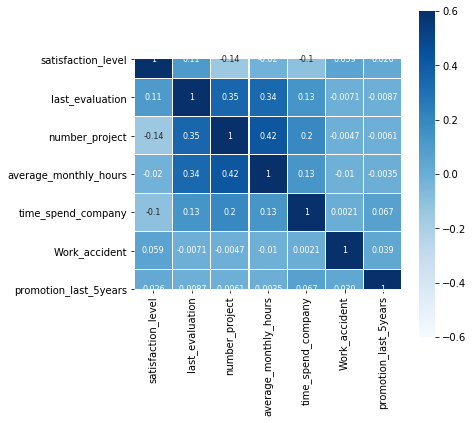

In [105]:
#Correlation among all numberical variables
corr = turnover[['satisfaction_level', 'last_evaluation', 'number_project',
       'average_monthly_hours', 'time_spend_company', 'Work_accident',
       'promotion_last_5years', 'salary']].corr()
plt.figure(figsize=(6,6))
sns.heatmap(corr[(corr >= 0.001) | (corr <= -0.001)],
           cmap = 'Blues', vmax = 0.6, vmin = -0.6, linewidths = 0.1,
           annot = True, annot_kws = {"size":8}, square = True)

In [106]:
#Mapping salary into numerical categories for the model relevance.
turnover["salary"] = turnover.salary.map({'low':1,'medium':2,'high':3})

In [107]:
#Dummy encoding of departments and dropping the column to avoid collinearity problem
turnover = pd.get_dummies(turnover, prefix=['department'], drop_first=True)

# Baseline Model

In [108]:
#df is the scaled dataframe with all the features
minmax = MinMaxScaler()
data_tf = minmax.fit_transform(turnover)
df = pd.DataFrame(data=data_tf)
df.columns = turnover.columns

y = df['left']
X = df.drop('left', axis=1)
# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

#Baseline
Baselinelogreg = LogisticRegression(solver='lbfgs').fit(X_train, y_train)
BaselinePrediction = Baselinelogreg.predict(X_test)
print(classification_report(y_test, BaselinePrediction))

              precision    recall  f1-score   support

         0.0       0.82      0.93      0.87      2262
         1.0       0.63      0.38      0.47       738

    accuracy                           0.79      3000
   macro avg       0.73      0.65      0.67      3000
weighted avg       0.77      0.79      0.77      3000



# Feature importance

In [109]:
#Function for plotting feature importance
def plot_importance(features: List[str], importances: List[float]):
    
    num_features = len(features)
    indices = np.argsort(importances)
    
    plt.figure(figsize=(8,10))
    plt.title("Feature importance")
    plt.barh(range(num_features), importances[indices],
             color="b", 
             xerr=np.std(importances), 
             align="center")
    plt.yticks(range(num_features), features[indices])
    plt.ylim([-1, num_features])
    plt.show()

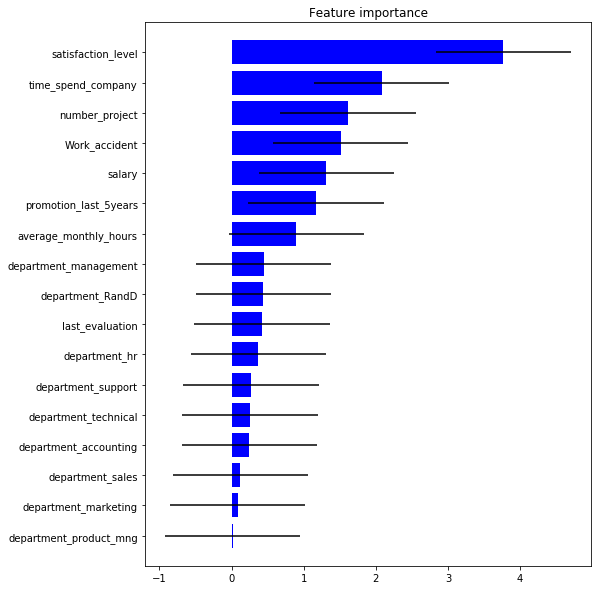

In [110]:
#Plotting feature importance based on logistic regression
plot_importance(X_test.columns, np.abs(Baselinelogreg.coef_[0]))

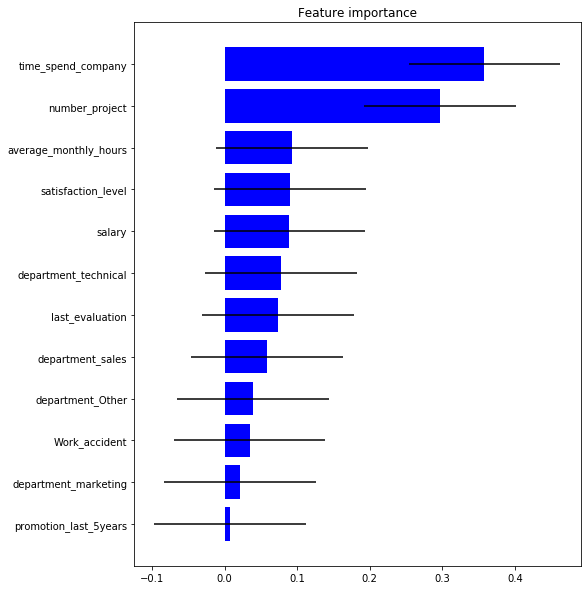

In [23]:
#Plotting feature importance based on Relieff
fs = ReliefF(n_features_to_select=10, n_neighbors=20)
fs.fit(X_train.values, y_train.values)
Important_features = fs.transform(X_train.values)
plot_importance(X_train.columns, abs(fs.feature_importances_))

# Feature engineering

1) Binning & replacing outliers

In [111]:
#Replacing outliers with the highest tenure since the outliers are skewed to the right.
turnover.loc[turnover['time_spend_company'] > 5, ['time_spend_company']] = 5

In [112]:
#Binning of number of hours into three categories ("low, mid and high workload").
#By average of OECD countries, the average weekly hours is ~38, which can be used to establish bins.
pd.cut(turnover['average_monthly_hours'], bins = [96,150,226,310], labels=["1", "2", "3"])


0        2
1        3
2        3
3        2
4        2
        ..
14994    2
14995    2
14996    1
14997    3
14998    2
Name: average_monthly_hours, Length: 14999, dtype: category
Categories (3, object): [1 < 2 < 3]

In [113]:
#df is the scaled dataframe with all the features
minmax = MinMaxScaler()
data_tf = minmax.fit_transform(turnover)
df = pd.DataFrame(data=data_tf)
df.columns = turnover.columns

y = df['left']
X = df.drop('left', axis=1)
# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

#Second try after the BL
logreg2 = LogisticRegression(solver='lbfgs')
logreg2.fit(X_train, y_train)
print(cross_val_score(logreg2,X_train,y_train,cv=10,scoring="f1_macro"))
Prediction2 = logreg2.predict(X_test)
print(classification_report(y_test, Prediction2))

[0.65696434 0.65428438 0.66500424 0.69435604 0.64017198 0.70748798
 0.66834484 0.68937019 0.66454982 0.67714752]
              precision    recall  f1-score   support

         0.0       0.82      0.91      0.86      2262
         1.0       0.59      0.39      0.47       738

    accuracy                           0.78      3000
   macro avg       0.70      0.65      0.67      3000
weighted avg       0.76      0.78      0.77      3000



2) Creation of new feature by means of product of 2 features

In [117]:
#Multiplying two most important columns first by logit and second by Relieff importance to potentialize the interaction.
#1) Normally tenure in the company has cumulative effect, so low satisfaction during long time of employment can effect attrition adverselely.
#2) To potentialize interaction between average hours and number of projects as a measure to make a prediction

df['Mult'] = df.satisfaction_level * df.time_spend_company
df['Mult2'] = df.average_monthly_hours * df.number_project

In [118]:
#Drop departments as they do not represent important features based on both methods of feature importance
df.columns
y = df['left']
X=df[['satisfaction_level', 'last_evaluation', 'number_project',
       'average_monthly_hours', 'time_spend_company', 'Work_accident',
       'promotion_last_5years', 'salary', 'Mult','Mult2']]

#Setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

#Third try after BL
logreg3 = LogisticRegression(solver='lbfgs') 
logreg3.fit(X_train, y_train)
print(cross_val_score(logreg2,X_train,y_train,cv=10,scoring="f1_macro"))
logreg3Prediction = logreg3.predict(X_test)
print(classification_report(y_test, logreg3Prediction))


[0.88064608 0.8508891  0.86892154 0.86379928 0.86517109 0.8810364
 0.87810669 0.88395243 0.88796086 0.87520148]
              precision    recall  f1-score   support

         0.0       0.94      0.95      0.94      2262
         1.0       0.83      0.81      0.82       738

    accuracy                           0.91      3000
   macro avg       0.88      0.88      0.88      3000
weighted avg       0.91      0.91      0.91      3000



3) Upsampling the data. 
Although 24% of leavers is arguable to be considered as unbalanced, by the tenure of employees we can consider the company young. By number of employees in sales and tech, we can consider it as a tech company, which makes the attrition odds higher. So it would be importance the see the accuracy for leavers, especially for the short run solution.

In [119]:
#Upsampling
X1 = pd.concat([X_train, y_train], axis=1)

In [120]:
#Separate minority and majority 
not_left = X1[X1.left==0]
left = X1[X1.left==1]

In [121]:
#Upsample minority
left_upsampled = resample(left,
                          replace=True, #Sample with replacement
                          n_samples=len(not_left), #Match number in majority class
                          random_state=100) #Reproducible results

In [122]:
#Combine majority and upsampled minority
upsampled = pd.concat([not_left, left_upsampled])
#Check new class counts
upsampled.left.value_counts()

1.0    9166
0.0    9166
Name: left, dtype: int64

In [123]:
y_train = upsampled['left']
X_train = upsampled.drop('left', axis=1)
X1 = upsampled.drop('left', axis=1)
y1 = upsampled['left']

#Setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.2, random_state=101)

#Fourth try
logreg4 = LogisticRegression(solver='lbfgs')
logreg4.fit(X_train, y_train)
print(cross_val_score(logreg4,X_train,y_train,cv=10,scoring="f1_macro"))
logreg4Prediction = logreg4.predict(X_test)
print(classification_report(y_test, logreg4Prediction))

[0.89153712 0.89354176 0.89286417 0.90031593 0.89760453 0.88877537
 0.90171426 0.89957533 0.89066392 0.90097156]
              precision    recall  f1-score   support

         0.0       0.92      0.85      0.88      1825
         1.0       0.86      0.92      0.89      1842

    accuracy                           0.89      3667
   macro avg       0.89      0.89      0.89      3667
weighted avg       0.89      0.89      0.89      3667



4) The product of key variables showed better average results and would be a better model for a long run.
Based on that, last try could be polynomial features of degree two without self interaction to avoid complexity.

In [124]:
pol = PolynomialFeatures(2,interaction_only=True)

In [125]:
#Drop multiplicated features as polynomial will capture them anyway.
df.columns
X=df[['satisfaction_level', 'last_evaluation', 'number_project',
       'average_monthly_hours', 'time_spend_company', 'Work_accident',
       'promotion_last_5years', 'salary']]



In [126]:
#Polynomial logistic regression - Fourth try
X_train, X_test, y_train, y_test = train_test_split(pol.fit_transform(X), y)
logreg5 = LogisticRegression(solver='lbfgs',max_iter=500)
print(cross_val_score(logreg5,X_train,y_train,cv=10,scoring="f1_macro"))
logreg5.fit(X_train, y_train)
#The support is the number of occurrences of each class in y_test
prediction5 = logreg5.predict(X_test)
print(classification_report(y_test, prediction5))

[0.94069321 0.9238823  0.93273586 0.92447581 0.91812083 0.93064336
 0.91806005 0.92235336 0.92518563 0.91835863]
              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97      2887
         1.0       0.89      0.89      0.89       863

    accuracy                           0.95      3750
   macro avg       0.93      0.93      0.93      3750
weighted avg       0.95      0.95      0.95      3750



In [127]:
features = pol.get_feature_names(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_monthly_hours', 'time_spend_company', 'Work_accident',
       'promotion_last_5years', 'salary'])

CV for optimizing parameters of the final model

In [131]:
#Grid search cross validation
parameters = {
    'C': np.linspace(1, 20, 20)
             }
lr = LogisticRegression(solver = 'lbfgs', max_iter=500)
clf = GridSearchCV(lr, parameters, cv=5, verbose=5, n_jobs=3, scoring="f1_macro")
clf.fit(X_train, y_train.ravel())

print("tuned hpyerparameters :(best parameters) ",clf.best_params_)
print("accuracy :",clf.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:    1.9s
[Parallel(n_jobs=3)]: Done  66 tasks      | elapsed:   20.2s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:   31.4s finished


tuned hpyerparameters :(best parameters)  {'C': 18.0}
accuracy : 0.9297936038015058


In [132]:
#Polynomial logistic regression - CV
X_train, X_test, y_train, y_test = train_test_split(pol.fit_transform(X), y)
logregCV = LogisticRegression(solver='lbfgs', max_iter=500, C=20,penalty='l2', verbose=0)
logregCV.fit(X_train, y_train)
#The support is the number of occurrences of each class in y_test
prediction = logregCV.predict(X_test)
print(classification_report(y_test, prediction))


              precision    recall  f1-score   support

         0.0       0.96      0.97      0.96      2836
         1.0       0.90      0.88      0.89       914

    accuracy                           0.95      3750
   macro avg       0.93      0.92      0.93      3750
weighted avg       0.95      0.95      0.95      3750



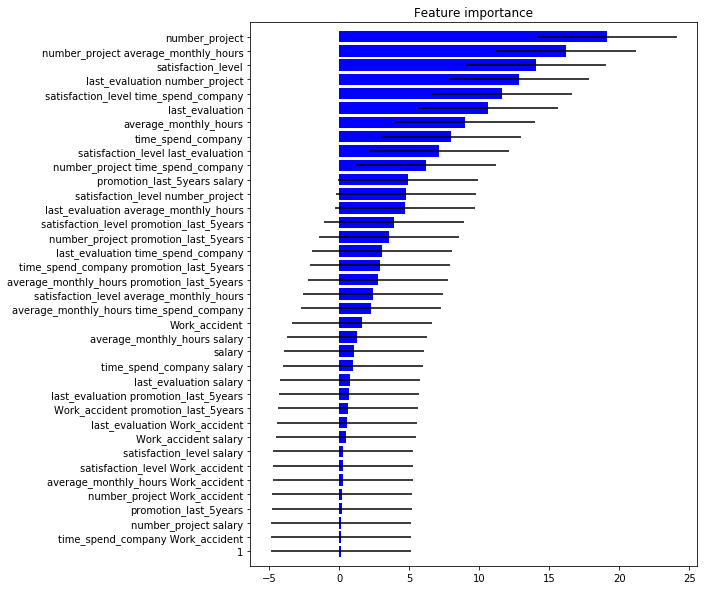

In [133]:
#Plotting feature importance based on Polynomial logistic regression, where interaction of features is shown to the left.
plot_importance(np.array(features), np.abs(logregCV.coef_[0]))

# Conclusion
The main cause of employee attrition seems to be caused by consistently low satisfaction level over a few years, which in turn can be impacted by too many projects being assigned to those already working more than the average amount per week. For a short run, more attention should be drawn to those employees that have tenure of 3-5 years. Product of key features seems to potentialize interaction. Normally tenure in the company has cumulative effect, so low satisfaction during long time of employment can effect attrition even more adversely. 


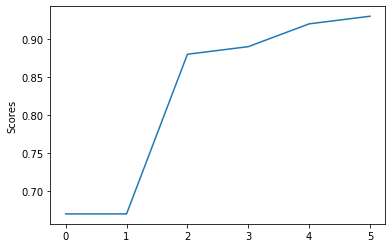

In [116]:
plt.plot([0.67,0.67,0.88, 0.89, 0.92, 0.93])
plt.ylabel('Scores')
plt.show()